<a target="_blank" href="https://colab.research.google.com/github/wbfrench1/barker_DATA606/blob/main/src/crf_models/CRF_NER_Model_w_Grid_Search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [6]:
# Ran into the following error: AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# Used below resolution
#https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
!pip install -U 'scikit-learn<0.24'
!pip install sklearn-crfsuite
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.23.2-cp39-cp39-linux_x86_64.whl size=24678655 sha256=0754c272d5ecd1a8d5a216ea1f4e28029856663a3bd530d70273db3ba8a8e2d3
  Stored in directory: /root/.cache/pip/wheels/5e/74/24/7e235ccf01765c0daa089c98cc823e9dc1383da5fe0ed7e224
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requi

In [7]:
import os
!wget https://github.com/wbfrench1/barker_DATA606/blob/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py?raw=true
os.rename('/content/crf_functions_w2v.py?raw=true', '/content/crf_functions_w2v.py')

--2023-04-22 23:45:09--  https://github.com/wbfrench1/barker_DATA606/blob/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wbfrench1/barker_DATA606/raw/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py [following]
--2023-04-22 23:45:09--  https://github.com/wbfrench1/barker_DATA606/raw/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wbfrench1/barker_DATA606/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py [following]
--2023-04-22 23:45:09--  https://raw.githubusercontent.com/wbfrench1/barker_DATA606/747af2fa4de8e80c66baf1f8ad750d

In [8]:
import eli5
import crf_functions_w2v as funcs
from google.colab import drive
import requests
import pandas as pd
import random
import numpy as np
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
import joblib
from sklearn_crfsuite import metrics as crf_metrics
import nltk
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy.stats
from collections import Counter
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 1. Read in the Data

##   1.a. Read in the Sarkar data
##   1.b. Read in the movie data


In [9]:
df = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/05c1c56275fcaf7e4df300b578f65f62127dad18/data/movie_data.csv?raw=true')

# 2. Explore the Data

In [10]:
# Differentiate the question columns.  q_num is absoloute, while
## q_num_by_src is a numbering for each of the four, movie data
### sets
df.rename(columns={'quest_num':'q_num_by_src',
                   'label': 'postag',
                   'entity' : 'tag'}, inplace=True)

In [11]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322035 entries, 0 to 322034
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   q_num_by_src  322035 non-null  int64 
 1   postag        322035 non-null  object
 2   word          322034 non-null  object
 3   pos           322035 non-null  object
 4   tag           322035 non-null  object
 5   source        322035 non-null  object
 6   q_num         322035 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 17.2+ MB


In [13]:
df.tag.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer', 'award',
       'origin', 'relationship', 'quote'], dtype=object)

In [14]:
df.tag.value_counts()

outside         145975
plot             89414
actor            22326
genre            13479
year             10246
director          8798
rating            7969
title             7289
origin            5117
character         3187
relationship      2246
review            2141
quote             1339
award             1241
song              1110
trailer            158
Name: tag, dtype: int64

In [15]:
df['q_num'].nunique(), df['word'].nunique(), df['pos'].nunique(), df['tag'].nunique()

(21987, 15336, 3, 16)

# 3. Create features in the data

## 3.1 Convert Movie Data Format

In [16]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [17]:
# copy original data
df1 = df.copy()

In [18]:
df1.columns

Index(['q_num_by_src', 'postag', 'word', 'pos', 'tag', 'source', 'q_num'], dtype='object')

In [19]:
# remove the extra columns
df1.drop(columns=['q_num_by_src', 'pos', 'tag', 'source'], inplace=True)

In [20]:
df1.head()

,postag,word,q_num
0,o-outside,what,1
1,o-outside,movies,1
2,o-outside,star,1
3,b-actor,bruce,1
4,i-actor,willis,1


In [21]:
#convert the word format to string
#rename the columns to match the Sarkar Tool
df1.word = df1.word.astype(str)
df1.rename(columns={'q_num': 'Sentence #',
                    'word': 'Word',
                    'postag': 'Tag'}, inplace=True)

In [22]:
# check for null values
df1.loc[df1.Word.isnull()]

,Tag,Word,Sentence #


In [23]:
df1.dropna(inplace=True)

In [24]:
# create the part of speech (POS) variable
df1['POS'] = [pos for word, pos in nltk.pos_tag(df1['Word'])]

In [25]:
df1.head()

,Tag,Word,Sentence #,POS
0,o-outside,what,1,WP
1,o-outside,movies,1,NNS
2,o-outside,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [26]:
# update the 'o-outside tag to o
df1['Tag'].replace({'o-outside': 'o'}, inplace=True)

In [27]:
df1.head()

,Tag,Word,Sentence #,POS
0,o,what,1,WP
1,o,movies,1,NNS
2,o,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [28]:
agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                 s['POS'].values.tolist(),
                                                 s['Tag'].values.tolist()
                                                 )
                                                 ]

In [29]:
# create the initial data format list of tuples (Word, POS, Tag)
grouped_df1 = df1.groupby('Sentence #').apply(agg_func)
l_sentences = [s for s in grouped_df1]

In [30]:
# view the list of sentence lists, where each sentence is a list of word tuples
# in the order of the original sentence. 
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [31]:
# make the feature set
X = np.array([funcs.sent2features(s) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [32]:
# view the resulting feature of the first sentences first word
X[0][0]

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 42)
X_train.shape, X_test.shape

((17589,), (4398,))

# 4. Implement Model for Movie Data

In [75]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [30]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f7eab440790>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f7ea5c372e0>}

In [31]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [32]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)

In [33]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 28.7min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7eab440790>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7ea5c372e0>},
                   scoring=make_scorer(flat_...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [34]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.49403956270481464, 'c2': 0.0222052440324898}
best CV score: 0.8606281534420749
model size: 3.15M


In [35]:
rs.cv_results_

{'mean_fit_time': array([113.96354079, 108.07429417, 110.66493837, 107.7358199 ,
        107.81178053, 105.63165299, 106.81216121, 111.54004947,
        107.84819015, 106.97628427]),
 'std_fit_time': array([4.36897676, 3.45005863, 4.68870662, 2.28981081, 0.81498423,
        1.57973296, 1.46070397, 0.78904306, 1.3436942 , 4.15175272]),
 'mean_score_time': array([3.79970503, 3.67071827, 3.60356887, 2.87226756, 4.01358668,
        3.10019215, 3.12917757, 3.51774772, 3.02255551, 2.70363013]),
 'std_score_time': array([0.55539303, 0.64176023, 0.60000277, 0.36410787, 0.51273615,
        0.31025897, 0.67920417, 1.0455527 , 0.160471  , 0.81288507]),
 'param_c1': masked_array(data=[0.7216194464660783, 0.3788259513498636,
                    0.25778705564541426, 2.21519073926155,
                    1.376421168872394, 0.47835928424843016,
                    0.3253478235062954, 0.15113971697862835,
                    0.49403956270481464, 0.4993065859968735],
              mask=[False, False, Fa

Dark blue => 0.8524, dark red => 0.8606


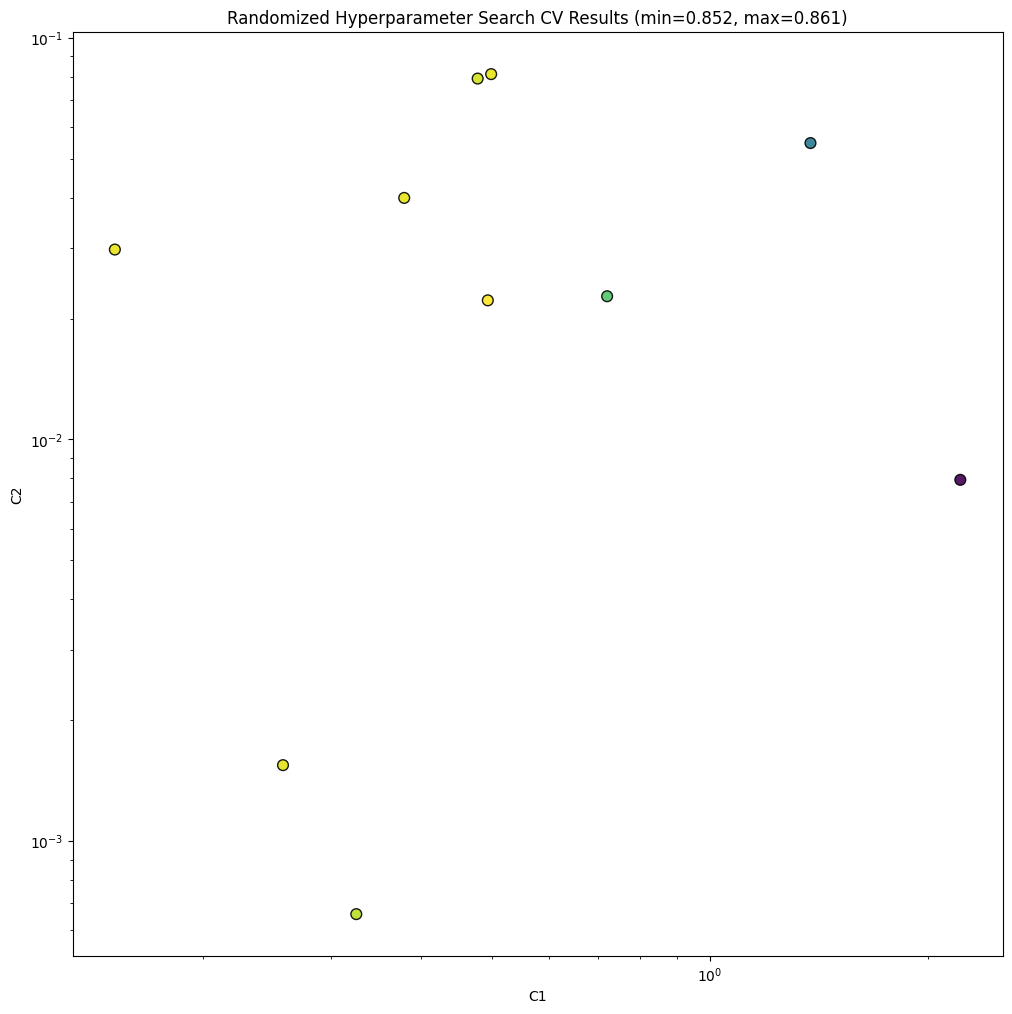

In [36]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [37]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.903     0.905     0.904     29657
       b-actor      0.919     0.919     0.919      2065
       i-actor      0.918     0.916     0.917      2417
       b-award      0.646     0.525     0.579        80
       i-award      0.663     0.595     0.627       195
   b-character      0.757     0.435     0.552       359
   i-character      0.721     0.491     0.584       269
    b-director      0.854     0.823     0.838       864
    i-director      0.867     0.835     0.851       880
       b-genre      0.872     0.877     0.875      1928
       i-genre      0.771     0.710     0.740       708
      b-origin      0.448     0.335     0.383       179
      i-origin      0.613     0.682     0.646       733
        b-plot      0.504     0.454     0.478      2027
        i-plot      0.854     0.918     0.885     14978
       b-quote      0.500     0.290     0.367        31
       i-quote      0.578     0.536     0.557  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<Axes: >

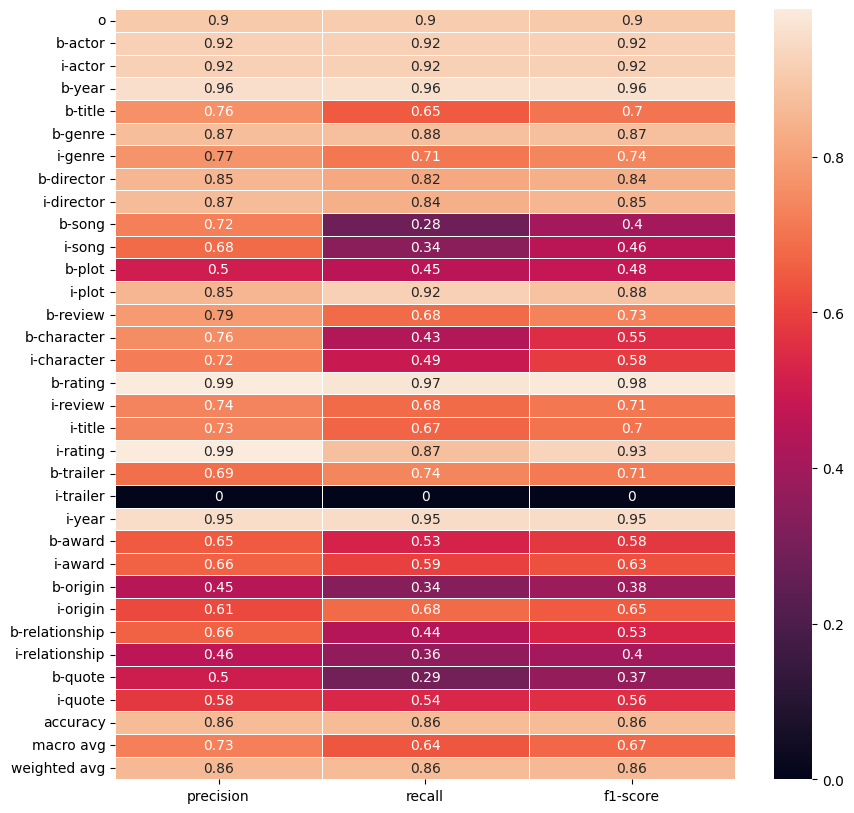

In [38]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

In [39]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
i-origin -> i-origin 6.148001
b-origin -> i-origin 6.037568
b-song -> i-song  5.853072
b-title -> i-title 5.797715
i-quote -> i-quote 5.712979
i-relationship -> i-relationship 5.623009
b-director -> i-director 5.563864
b-actor -> i-actor 5.484540
i-song -> i-song  5.431589
i-plot -> i-plot  5.392009
b-relationship -> i-relationship 5.292764
i-title -> i-title 5.152471
i-year -> i-year  4.807536
b-character -> i-character 4.757838
b-plot -> i-plot  4.635884
b-award -> i-award 4.550382
b-rating -> i-rating 4.440232
i-review -> i-review 4.411516
i-character -> i-character 4.226618
i-award -> i-award 4.225589

Top unlikely transitions:
i-actor -> b-actor -4.556569
i-plot -> b-title -4.632601
i-actor -> i-plot  -4.641940
i-plot -> i-actor -4.723344
o      -> i-song  -5.144326
o      -> i-rating -5.204076
b-genre -> b-genre -5.267734
o      -> i-origin -5.366801
o      -> i-relationship -5.422886
o      -> i-director -5.481035
o      -> i-award -5.502314
o      -> i-q

In [40]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,2.044,1.256,-6.419,0.15,-5.502,0.856,-6.094,0.865,-5.481,0.676,-5.791,0.775,-5.367,0.941,-7.682,0.237,-5.711,0.392,-5.204,0.369,-5.423,1.07,-6.466,0.668,-5.144,0.935,-6.385,0.101,-3.971,0.842,-6.495
b-actor,-0.743,-2.659,5.485,-0.671,-1.822,-2.237,-2.607,-1.087,-2.475,-1.959,-1.672,-1.039,-1.527,-0.555,-3.075,-1.475,-1.815,-1.11,-0.555,-1.488,-1.284,-1.045,-2.019,-1.032,-1.471,-2.621,-2.404,-0.678,0.0,-0.564,-1.033
i-actor,0.795,-4.557,3.316,0.018,-2.836,-1.472,-3.212,-3.273,-3.081,0.749,-2.774,-0.803,-2.625,0.804,-4.642,-1.751,-2.918,-0.163,-1.722,-1.961,-2.337,0.087,-3.394,-1.527,-2.329,-2.715,-2.632,-0.692,-0.825,0.724,-1.816
b-award,-0.09,-0.896,-0.636,-0.002,4.55,-0.127,-0.17,-0.795,-0.252,-2.66,-0.501,-0.005,-0.186,-1.745,-2.063,0.0,-0.008,-0.261,0.0,-0.003,-0.016,-0.333,-0.344,-0.001,-0.002,-0.287,-0.509,0.0,0.0,-0.005,-0.145
i-award,-0.141,-0.185,-1.5,-0.057,4.226,-0.291,-0.335,-0.023,-1.251,-0.254,-1.114,0.003,-0.628,-1.882,-2.609,-0.004,-0.061,-0.137,-0.004,0.005,-0.094,-0.02,-0.439,-0.002,-0.064,-0.485,-0.934,-0.002,0.0,-0.065,-0.508
b-character,-0.324,-1.926,-3.118,-0.213,-0.57,-0.947,4.758,-2.323,-2.405,-2.539,-1.717,-0.433,-1.473,1.642,-3.557,-0.043,-0.66,-0.917,-0.392,-0.305,-1.065,-1.113,-1.311,-0.233,-0.472,-1.128,-2.397,-0.007,0.0,-1.444,-0.985
i-character,0.097,-1.074,-2.514,-0.016,-0.312,-0.524,4.227,-1.499,-1.46,-1.071,-1.297,-0.315,-1.13,1.715,-3.543,0.003,-0.431,-0.495,-0.043,-0.001,-0.665,-0.446,-0.788,-0.033,-0.3,-0.793,-1.445,-0.006,0.0,-1.126,-0.681
b-director,0.109,-2.41,-3.339,-0.306,-1.636,-1.207,-2.576,-2.826,5.564,-0.051,-2.283,-0.359,-1.68,-1.519,-2.847,-0.636,-1.246,-1.652,-0.721,0.003,-1.464,0.066,-1.877,-0.957,-1.367,0.083,-2.182,-0.163,0.0,-0.087,-1.16
i-director,0.807,-1.565,-3.076,0.0,-1.259,-1.438,-2.532,-2.125,3.672,1.51,-2.821,-0.005,-1.96,-0.333,-3.27,-0.549,-1.407,0.144,-0.902,0.124,-1.515,0.571,-2.463,-0.631,-1.048,-1.321,-2.441,-0.112,0.0,0.622,-1.848
b-genre,0.516,0.0,-3.417,-0.046,-2.402,-2.032,-2.568,0.211,-2.759,-5.268,3.812,0.332,-2.53,0.465,-3.693,-1.466,-1.865,0.278,-1.336,0.625,-2.699,0.777,-2.778,-1.938,-1.908,-1.61,-2.752,-0.769,-0.038,0.858,-1.711


## Implement CRF with Word2Vec in feature vector

### Create Word2Vec vectors

In [34]:
# convert the list of sentence lists of word tuples into just a list
# sentences words
l_sents = [[tup[0] for tup in l_sent] for l_sent in l_sentences[0:]]

In [35]:
print('sentence example 1:', l_sents[0])
print('sentence example 2:', l_sents[1])
print('number of sentences:', len(l_sents))
print ('number of unique words:' , len(set([word for sent in l_sents for word in sent ])))

sentence example 1: ['what', 'movies', 'star', 'bruce', 'willis']
sentence example 2: ['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']
number of sentences: 21987
number of unique words: 15337


In [36]:
# define the parameters of word2vec model
feature_size = 12
window_context = 30
min_word_count = 1
sample = 1e-3

In [37]:
#instantiate the model
word2vec.Word2Vec()

In [38]:
# create the word2vec vectors
w2v_model = word2vec.Word2Vec(l_sents, 
                  vector_size= feature_size,
                  window = window_context,
                  min_count= min_word_count,
                  sample = sample,
                  )

In [39]:
# validate that words have vectors
w2v_model.wv['barrymore']

array([ 0.30947864, -0.12742366,  0.16187122, -0.36064965, -0.4545155 ,
        0.1875474 , -0.01340463,  0.10886294,  0.0365756 , -0.0290023 ,
        0.6746495 , -0.1822707 ], dtype=float32)

In [40]:
w2v_model.wv.similarity('fire', 'star')

0.6236272

In [41]:
funcs.create_w2v_feature_dict(w2v_model, 'barrymore')

{'w2v_0': 0.30947864,
 'w2v_1': -0.12742366,
 'w2v_2': 0.16187122,
 'w2v_3': -0.36064965,
 'w2v_4': -0.4545155,
 'w2v_5': 0.1875474,
 'w2v_6': -0.013404634,
 'w2v_7': 0.108862944,
 'w2v_8': 0.036575604,
 'w2v_9': -0.029002298,
 'w2v_10': 0.6746495,
 'w2v_11': -0.1822707}

In [42]:
w2v_model.wv.most_similar('bruce')

[('swayze', 0.9832966923713684),
 ('pitt', 0.9803491234779358),
 ('drew', 0.9772953391075134),
 ('vince', 0.9766426682472229),
 ('arnold', 0.9748625159263611),
 ('daryl', 0.974415123462677),
 ('abdul', 0.9742463231086731),
 ('winslet', 0.9740342497825623),
 ('timothy', 0.9738237857818604),
 ('gibney', 0.9735561609268188)]

In [43]:
w2v_model.wv.get_normed_vectors()

array([[-0.08955386,  0.1089698 ,  0.31414154, ...,  0.11921766,
         0.5532416 ,  0.04718626],
       [ 0.02122088, -0.11300007,  0.05269267, ..., -0.10693143,
         0.62049204, -0.08394085],
       [ 0.0362892 , -0.35023284,  0.08592753, ..., -0.07527038,
         0.59635293,  0.05196929],
       ...,
       [ 0.4222844 ,  0.51547945,  0.10622171, ..., -0.55238473,
        -0.06730407,  0.28984177],
       [-0.10867023,  0.34663504,  0.4020794 , ..., -0.24383633,
         0.29826066, -0.10350278],
       [-0.25783092, -0.33881548, -0.12729199, ..., -0.25460556,
         0.46978626,  0.25141802]], dtype=float32)

# Word2Vec: Create features in the data include W2V Vector

In [52]:
#grouped_df is a series NOT a dataframe
#each entry in the series is a list
# the elements in the list are tuples, 
#        - first entry is a sentence word
#        - second entry is a POS tag
#        - third entry is a IOB tag
grouped_df1[1]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [53]:
# Standard tokenized sentence with POS and NER tags
# list of lists of tuples, where the list contains sentences reprsented as lists.
# Each sentence list contains a word in the sentence along with the POS and NER
l_sentences = [s for s in grouped_df1]
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [54]:
import importlib
importlib.reload(funcs)

<module 'crf_functions_w2v' from '/content/crf_functions_w2v.py'>

In [55]:
funcs.word2features_w2v(l_sentences[0], 0, w2v_model)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'w2v_0': -0.13849202,
 'w2v_1': 2.7871273,
 'w2v_2': -0.21498023,
 'w2v_3': -3.5613062,
 'w2v_4': -6.7250204,
 'w2v_5': -0.1815518,
 'w2v_6': -1.8777349,
 'w2v_7': 1.5792913,
 'w2v_8': 0.6143894,
 'w2v_9': 0.40745583,
 'w2v_10': 1.2516544,
 'w2v_11': 0.8114365,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [56]:
# make the feature set
X = np.array([funcs.sent2features_w2v(s, w2v_model) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

# 4. Implement Model for Movie Data with word2vec

In [58]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [59]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f7e95e48f70>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f7e95ea56d0>}

In [60]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [61]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)

In [62]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 36.7min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7e95e48f70>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7e95ea56d0>},
                   scoring=make_scorer(flat_...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [63]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.18653324481860836, 'c2': 0.014438382676431702}
best CV score: 0.8629038508063548
model size: 3.50M


In [64]:
rs.cv_results_

{'mean_fit_time': array([135.32479088, 143.0431474 , 135.98672954, 131.96914132,
        133.56788103, 136.77174934, 128.43553758, 123.290042  ,
        124.86167526, 112.72456884]),
 'std_fit_time': array([ 3.17129591,  5.61961753,  6.2317357 ,  2.08779385,  8.22298577,
         1.31538401,  8.40755724,  2.15330674,  4.29164304, 15.50344309]),
 'mean_score_time': array([5.19759091, 4.32205192, 4.99321095, 5.72787102, 4.49473731,
        4.27023021, 5.34580684, 4.0955948 , 3.32287725, 2.79197884]),
 'std_score_time': array([1.45295487, 0.60341074, 0.94160717, 0.67526776, 1.44072466,
        1.14223795, 0.85646125, 0.69563844, 0.04858889, 0.70405203]),
 'param_c1': masked_array(data=[0.10895662164138269, 0.8478388230089697,
                    0.37805824438418123, 0.4427831932499081,
                    1.21496567886395, 1.0857054390638723,
                    0.1973322525075306, 0.06971131630264756,
                    0.18653324481860836, 0.47567965621902136],
              mask=[Fals

Dark blue => 0.8567, dark red => 0.8629


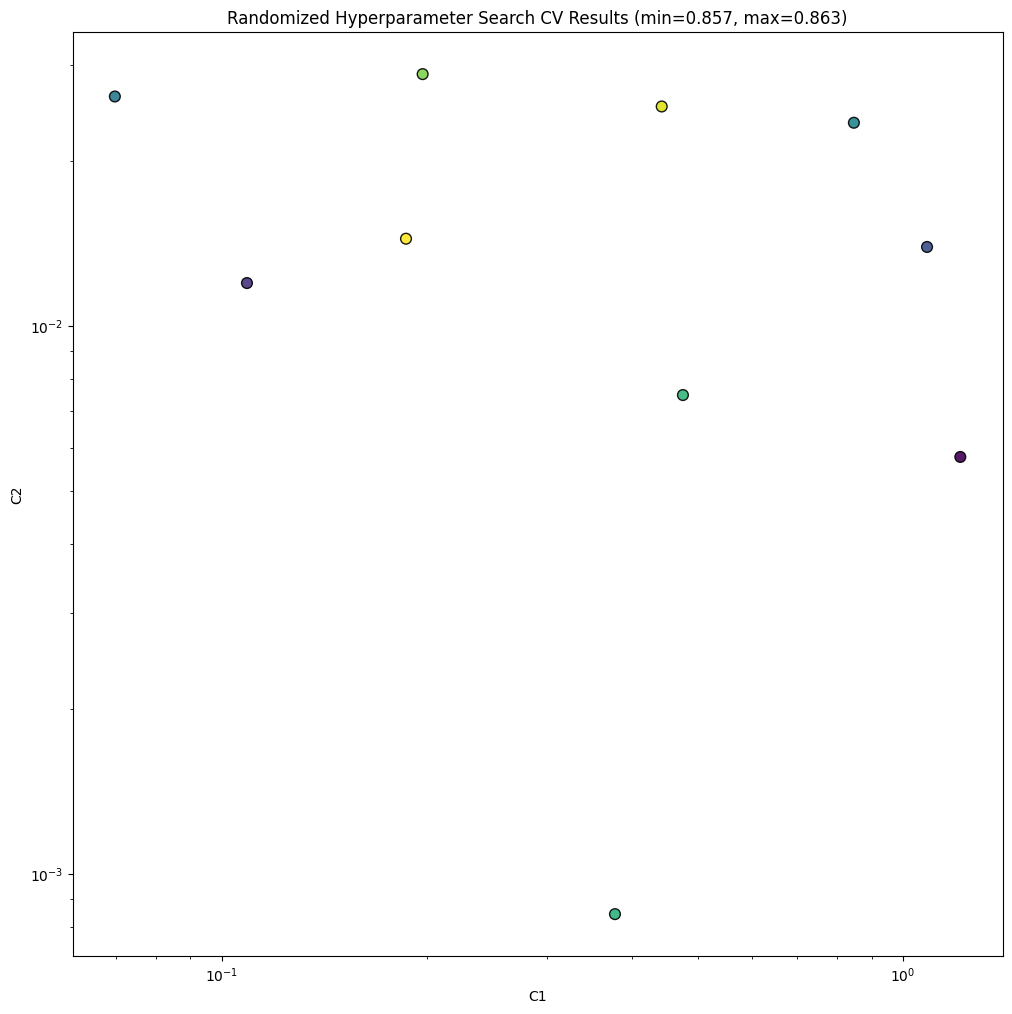

In [65]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [66]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.916     0.894     0.905     36962
       b-actor      0.918     0.936     0.927      2576
       i-actor      0.915     0.935     0.925      3010
       b-award      0.602     0.509     0.552       110
       i-award      0.676     0.697     0.686       267
   b-character      0.725     0.496     0.589       448
   i-character      0.669     0.528     0.590       345
    b-director      0.864     0.825     0.844      1076
    i-director      0.879     0.839     0.858      1096
       b-genre      0.876     0.892     0.884      2416
       i-genre      0.736     0.736     0.736       876
      b-origin      0.456     0.373     0.410       220
      i-origin      0.655     0.665     0.660       961
        b-plot      0.495     0.463     0.479      2565
        i-plot      0.841     0.923     0.880     19162
       b-quote      0.441     0.385     0.411        39
       i-quote      0.582     0.576     0.579  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<Axes: >

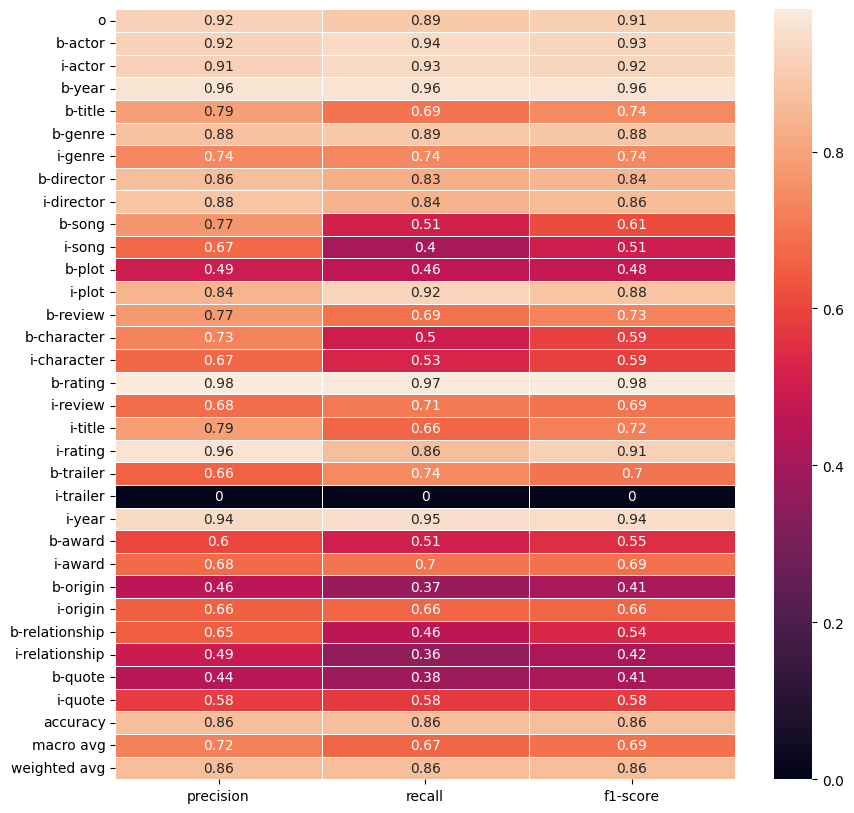

In [67]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

In [68]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
i-quote -> i-quote 6.565859
b-director -> i-director 5.753482
b-actor -> i-actor 5.501413
b-relationship -> i-relationship 5.468519
i-relationship -> i-relationship 5.438242
b-title -> i-title 5.162163
b-origin -> i-origin 5.071539
b-character -> i-character 4.809806
i-origin -> i-origin 4.766008
i-review -> i-review 4.669446
b-song -> i-song  4.593079
i-award -> i-award 4.543034
i-title -> i-title 4.542790
b-review -> i-review 4.512226
b-award -> i-award 4.476282
i-year -> i-year  4.380533
b-quote -> i-quote 4.152261
i-song -> i-song  4.090004
b-rating -> i-rating 3.869087
i-director -> i-director 3.627772

Top unlikely transitions:
o      -> i-award -6.036767
o      -> i-quote -6.093951
o      -> i-relationship -6.137817
i-plot -> i-actor -6.250946
b-genre -> b-genre -6.317762
i-plot -> i-year  -6.331719
i-plot -> i-title -6.618853
o      -> i-song  -6.658434
o      -> i-director -6.684685
i-actor -> i-plot  -6.697718
o      -> i-rating -6.782587
o      -> i-r

In [69]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,1.839,1.085,-7.661,0.011,-6.037,0.499,-7.092,0.988,-6.685,0.547,-7.861,0.219,-7.224,1.097,-9.536,0.535,-6.094,0.502,-6.783,0.171,-6.138,0.921,-6.818,0.513,-6.658,1.115,-7.445,0.056,-5.35,0.668,-7.524
b-actor,-0.657,-2.982,5.501,-0.684,-1.999,-3.11,-3.489,-0.854,-3.296,-1.75,-2.69,-1.907,-2.926,0.0,-4.866,-1.062,-2.023,-1.378,-1.517,-1.903,-1.725,-0.716,-2.039,-1.059,-2.289,-2.625,-3.163,-0.668,-0.546,-1.574,-2.549
i-actor,0.839,-4.698,3.524,-0.01,-3.372,-2.066,-3.878,-3.547,-3.523,0.608,-4.081,-0.744,-3.883,1.308,-6.698,-1.905,-3.999,-0.208,-2.662,-1.785,-2.607,0.224,-3.601,-1.06,-3.035,-2.173,-3.226,-0.591,-1.467,0.93,-3.108
b-award,-0.489,-2.368,-1.667,-0.065,4.476,-0.801,-1.227,-1.286,-0.977,-2.978,-1.732,-0.663,-1.161,-1.944,-3.456,-0.013,0.0,-0.553,-0.254,-0.859,-0.539,-1.635,-1.644,-0.014,-0.421,-0.473,-1.234,0.0,0.0,-0.049,-0.866
i-award,-0.057,-0.471,-1.88,-3.343,4.543,-1.166,-1.339,-0.044,-1.373,-0.658,-2.059,-0.001,-2.004,-2.533,-4.075,-0.172,0.0,0.0,-0.533,0.013,-0.942,-0.251,-2.245,-0.002,-1.527,-1.372,-1.812,-0.059,-0.0,-0.143,-2.146
b-character,0.035,-0.966,-3.12,-0.153,-1.55,-2.721,4.81,-2.001,-2.363,-2.858,-2.519,-1.927,-2.529,2.438,-5.011,-0.961,-1.59,-0.874,-1.09,-1.688,-1.344,-2.383,-1.616,-1.129,-1.789,-0.78,-2.634,-0.343,-0.02,-2.129,-2.013
i-character,-0.087,-0.804,-2.955,-0.428,-1.613,-3.583,3.551,-1.599,-1.925,-0.924,-2.2,-1.837,-2.58,1.765,-5.576,0.005,-1.409,-1.982,-1.718,-0.354,-1.873,-2.089,-2.154,-1.113,-1.297,-2.472,-2.756,-0.623,-0.582,-1.786,-1.964
b-director,0.081,-2.808,-4.095,-0.753,-1.859,-1.488,-3.189,-3.193,5.753,-0.114,-3.762,-0.272,-2.894,-0.926,-4.19,-1.427,-0.966,-2.026,-1.25,0.402,-1.491,0.233,-1.952,-1.246,-1.997,0.229,-2.928,-0.582,-0.213,-0.297,-2.166
i-director,0.83,-1.723,-3.637,-0.036,-2.359,-1.334,-2.212,-2.177,3.628,1.21,-4.109,-0.007,-3.968,0.005,-4.985,-1.342,-1.411,-0.028,-1.968,0.245,-1.925,0.217,-2.612,-1.262,-1.885,-1.469,-2.444,-0.596,-0.162,1.118,-2.625
b-genre,0.585,-0.38,-3.998,-0.002,-2.828,-1.984,-3.436,0.413,-3.281,-6.318,3.311,0.067,-4.001,0.407,-5.493,-1.81,-1.263,0.354,-2.563,0.397,-3.135,0.921,-3.037,-2.215,-2.804,-3.099,-3.563,-1.133,-1.001,0.672,-2.749


### Create Kmeans Word2Vec Clusters

In [44]:
# create a list of the word vectors
l_vectors = []
l_words = []
l_word_vector = []
i = 0
for word in w2v_model.wv.index_to_key:
    l_words.append(word)
    l_word_vector = w2v_model.wv[word]
    l_vectors.append(l_word_vector)
    i += 1
print('number of word vectors:', i)

number of word vectors: 15337


In [47]:
# calculate the silhouette score for each cluster number
l_num_clus = []
l_silhouette_scores = []

for num_clus in [10, 20, 50, 100, 250, 500, 1000]:
    print(num_clus)
    kmeans = KMeans(n_clusters= num_clus)
    kmeans.fit_predict(l_vectors)
    l_num_clus.append(num_clus)
    l_silhouette_scores.append(silhouette_score(l_vectors, kmeans.labels_))

10
20
50
100
250
500
1000


In [48]:
print('number of word labels:', len(kmeans.labels_))

number of word labels: 15337


In [49]:
print('number of cluster labels:', len(set(kmeans.labels_)))

number of cluster labels: 1000


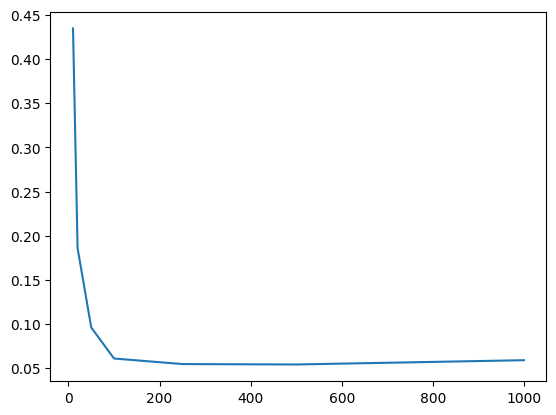

In [50]:
import matplotlib.pyplot as plt
plt.plot(l_num_clus,l_silhouette_scores)

In [51]:
# create a word to cluster dictionary

# create a list to hold the words in the word2vec object
l_word_to_cluster = []
l_word_cluster_number = []
l_word_vector

i = 0

for word in w2v_model.wv.index_to_key:
    l_word_to_cluster.append(word)
    l_word_vector = w2v_model.wv[word]
    l_word_cluster_number.append(kmeans.predict([l_word_vector])[0])
    i += 1

dict_word_cluster = dict(zip(l_word_to_cluster,l_word_cluster_number))
list(dict_word_cluster.items())[:5]

[('the', 64), ('a', 138), ('movie', 83), ('what', 97), ('in', 94)]

In [52]:
funcs.word2features_w2v_kmeans_clstr(l_sentences[0], 0, dict_word_cluster)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'kmeans_word2vec_clstr_num': 97,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [53]:
# make the feature set
X = np.array([funcs.sent2features_w2v_kmeans_clstr(s, dict_word_cluster) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

# 4. Implement Model for Movie Data with word2vec kmeans clusters

In [55]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [56]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6f8de91340>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6f9e7446d0>}

In [57]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [58]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)

In [59]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.1min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f6f8de91340>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f6f9e7446d0>},
                   scoring=make_scorer(flat_...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [60]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.5498877830112705, 'c2': 0.006490716984202909}
best CV score: 0.6399383154860901
model size: 4.12M


In [61]:
rs.cv_results_

{'mean_fit_time': array([107.94194031, 103.22541698, 104.11646692, 102.48652236,
        104.87895624, 102.184484  , 102.80061436, 100.72534243,
        103.08334653, 102.16084178]),
 'std_fit_time': array([2.88021676, 2.2950473 , 1.43731405, 1.856131  , 4.0756926 ,
        2.33193238, 2.43849341, 1.96482319, 3.15461993, 2.13451555]),
 'mean_score_time': array([2.4805758 , 3.05155492, 2.88727776, 2.50325807, 2.45737505,
        3.1419553 , 3.11130667, 3.14253251, 2.57254235, 3.53459422]),
 'std_score_time': array([0.11598014, 0.76985132, 0.30566898, 0.15017053, 0.02398527,
        0.59659063, 0.77322956, 0.57786943, 0.25088666, 0.59449053]),
 'param_c1': masked_array(data=[0.8035493187444998, 0.5828474961955034,
                    0.13265254083073885, 1.6317668312410691,
                    0.7060724570377616, 0.04832519718773421,
                    0.29584419126604233, 0.01782980861014047,
                    0.5498877830112705, 0.8700125733943221],
              mask=[False, False,

Dark blue => 0.5995, dark red => 0.6399


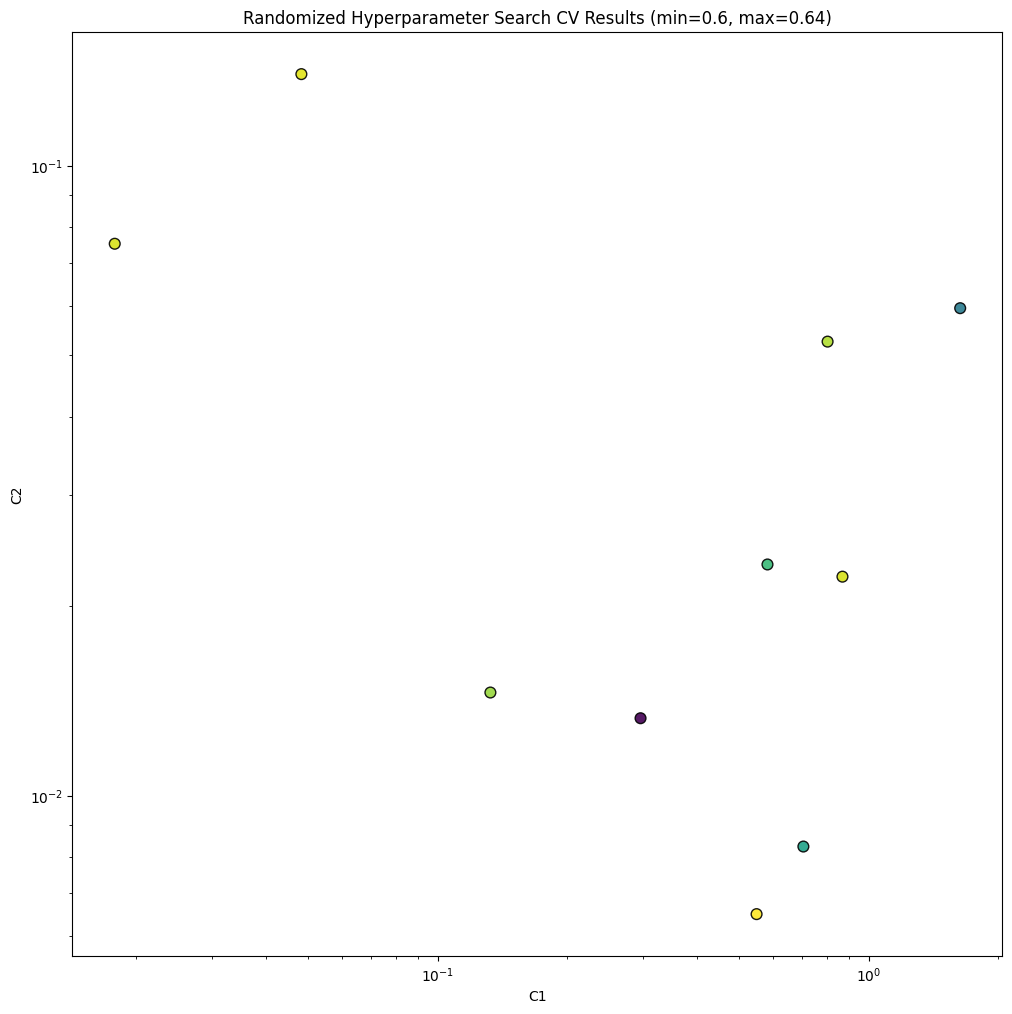

In [62]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [63]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.863     0.772     0.815     36962
       b-actor      0.575     0.667     0.617      2576
       i-actor      0.593     0.604     0.599      3010
       b-award      0.000     0.000     0.000       110
       i-award      0.000     0.000     0.000       267
   b-character      0.000     0.000     0.000       448
   i-character      0.011     0.003     0.005       345
    b-director      0.659     0.137     0.226      1076
    i-director      0.670     0.133     0.222      1096
       b-genre      0.661     0.535     0.591      2416
       i-genre      0.527     0.371     0.435       876
      b-origin      0.000     0.000     0.000       220
      i-origin      0.000     0.000     0.000       961
        b-plot      0.263     0.304     0.282      2565
        i-plot      0.575     0.951     0.716     19162
       b-quote      0.000     0.000     0.000        39
       i-quote      0.000     0.000     0.000  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<Axes: >

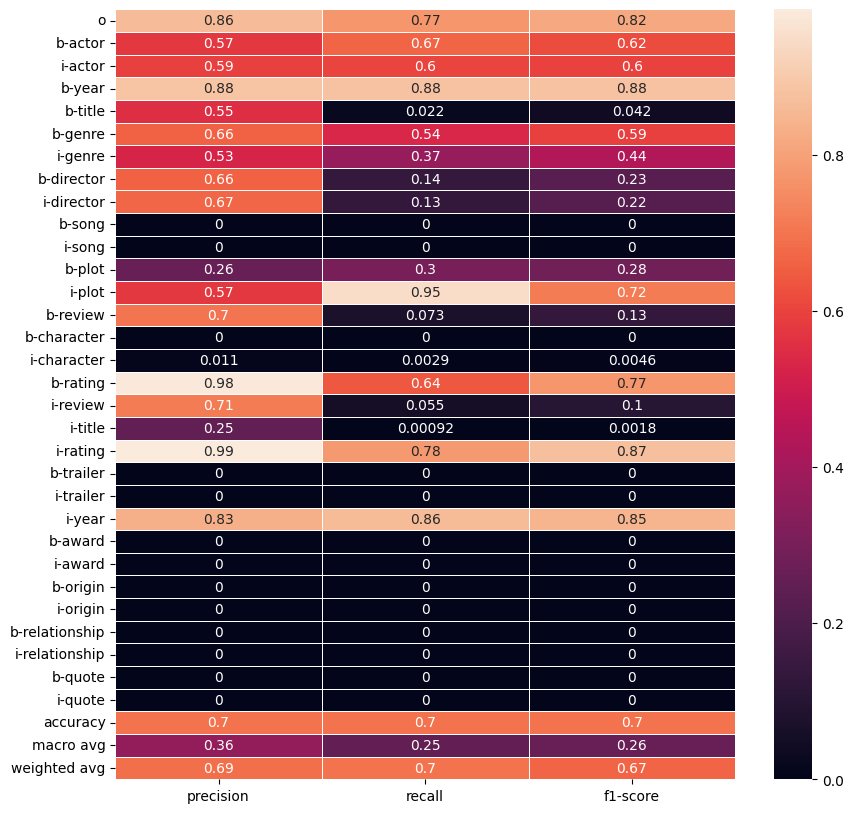

In [64]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

In [65]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
i-plot -> i-plot  3.822601
b-plot -> i-plot  3.520783
b-actor -> i-actor 3.388975
b-director -> i-director 3.277232
i-origin -> i-origin 2.782822
b-genre -> i-genre 2.447638
o      -> o       1.839300
b-year -> i-year  1.803366
b-title -> i-title 1.746246
i-title -> i-title 1.635384
b-review -> i-review 1.582277
o      -> b-actor 1.451064
o      -> b-rating 1.432995
o      -> b-review 1.292207
b-genre -> o       1.274528
i-actor -> o       1.172396
o      -> b-plot  1.162247
o      -> b-year  1.082167
o      -> b-genre 1.059603
i-relationship -> i-relationship 0.856451

Top unlikely transitions:
o      -> i-director -1.179502
i-plot -> o       -1.205104
b-title -> i-plot  -1.248298
i-plot -> i-title -1.263703
i-plot -> b-director -1.313463
i-plot -> i-director -1.382253
i-title -> i-plot  -1.407884
b-director -> i-plot  -1.464755
i-plot -> b-year  -1.515805
i-director -> i-plot  -1.530968
b-year -> i-plot  -1.673485
i-plot -> b-genre -1.746144
i-plot -> b-plot  

In [66]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,1.839,1.451,-2.385,0.001,-0.416,0.448,-0.681,0.639,-1.18,1.06,-0.76,0.237,-0.842,1.162,-6.901,-0.0,-0.537,1.433,-0.375,0.007,-0.549,1.292,-0.693,0.0,-0.444,0.169,-1.077,-0.0,-0.347,1.082,-0.737
b-actor,-2.085,-0.833,3.389,-0.149,-0.168,-0.302,-0.279,-0.458,-0.482,-0.614,-0.312,-0.187,-0.345,-0.465,-2.575,-0.142,-0.22,-0.185,-0.15,-0.212,-0.225,-0.322,-0.285,-0.153,-0.18,-0.388,-0.441,-0.142,-0.036,-0.529,-0.302
i-actor,1.172,-0.934,0.007,-0.022,-0.19,-0.339,-0.315,-0.518,-0.544,-0.078,-0.352,-0.204,-0.389,0.017,-2.952,-0.16,-0.248,-0.204,-0.17,-0.238,-0.254,-0.078,-0.321,-0.172,-0.204,-0.436,-0.498,-0.158,-0.056,-0.19,-0.341
b-award,-0.124,-0.16,-0.183,-0.001,0.206,-0.073,-0.05,-0.096,-0.099,-0.121,-0.075,-0.041,-0.079,-0.128,-0.508,-0.007,-0.044,-0.041,-0.038,-0.018,-0.044,-0.076,-0.07,-0.007,-0.04,-0.084,-0.092,-0.001,0.0,-0.052,-0.073
i-award,-0.002,-0.127,-0.206,-0.009,0.387,-0.08,-0.076,-0.012,-0.111,-0.094,-0.083,-0.001,-0.088,-0.145,-0.568,-0.001,-0.047,-0.043,-0.039,-0.002,-0.048,-0.06,-0.077,-0.001,-0.043,-0.094,-0.104,-0.009,0.0,-0.085,-0.08
b-character,-0.571,-0.319,-0.365,-0.072,-0.08,-0.13,0.842,-0.187,-0.195,-0.242,-0.134,-0.087,-0.146,0.002,-0.986,-0.05,-0.099,-0.086,-0.072,-0.096,-0.101,-0.138,-0.124,-0.073,-0.084,-0.161,-0.18,-0.05,-0.003,-0.212,-0.13
i-character,-0.002,-0.295,-0.338,-0.049,-0.076,-0.122,0.173,-0.174,-0.181,-0.223,-0.125,-0.082,-0.137,0.001,-0.915,-0.001,-0.094,-0.082,-0.05,-0.064,-0.095,-0.129,-0.116,-0.07,-0.08,-0.151,-0.168,-0.047,-0.001,-0.197,-0.122
b-director,-1.018,-0.477,-0.543,-0.093,-0.105,-0.182,-0.17,-0.273,3.277,-0.224,-0.189,-0.082,-0.208,-0.379,-1.465,-0.064,-0.135,-0.115,-0.094,-0.091,-0.138,-0.129,-0.173,-0.095,-0.112,-0.155,-0.262,-0.064,-0.006,-0.311,-0.183
i-director,0.593,-0.495,-0.568,-0.006,-0.108,-0.189,-0.177,-0.283,0.0,0.002,-0.196,-0.019,-0.216,-0.119,-1.531,-0.066,-0.14,-0.08,-0.096,-0.021,-0.143,-0.008,-0.18,-0.098,-0.115,-0.241,-0.274,-0.065,-0.006,-0.074,-0.19
b-genre,1.275,-0.441,-0.713,-0.082,-0.131,-0.232,-0.216,-0.221,-0.37,-0.471,2.448,-0.015,-0.266,-0.092,-1.931,-0.11,-0.17,-0.0,-0.117,-0.012,-0.174,-0.005,-0.22,-0.119,-0.14,-0.298,-0.338,-0.11,-0.028,-0.088,-0.233
